In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Chargement des données
df = pd.read_parquet("C:/Users/lisas/Downloads/df_final_15min_NoNan_20250505.parquet", engine="fastparquet")
df["heure_arrondie"] = pd.to_datetime(df["heure_arrondie"])
df = df.sort_values("heure_arrondie")



In [ ]:
# Découpage en train / test
df_train = df[df["heure_arrondie"] <= "2025-03-07"].copy()
df_test  = df[df["heure_arrondie"] >= "2025-03-08"].copy()

In [ ]:
# Normalisation de la cible
scaler = MinMaxScaler()
df_train['vitesse_scaled'] = scaler.fit_transform(df_train[['vitesse']])
df_test['vitesse_scaled']  = scaler.transform(df_test[['vitesse']])



In [ ]:
# Fonction pour créer les séquences par tronçon 
def make_sequences_with_time(df, value_col='vitesse_scaled', time_col='heure_arrondie', id_col='nom_du_troncon', window_size=24):
    X, y, times, troncons = [], [], [], []
    for troncon, group in df.groupby(id_col):
        group = group.sort_values(time_col)
        values = group[value_col].values
        times_vals = group[time_col].values
        for i in range(len(group) - window_size):
            X.append(values[i : i + window_size])
            y.append(values[i + window_size])
            times.append(times_vals[i + window_size])
            troncons.append(troncon)
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y)
    return X, y, times, troncons



In [ ]:
# Création des séquences
window_size = 24
X_train, y_train, times_train, troncons_train = make_sequences_with_time(df_train, window_size=window_size)
X_test, y_test, times_test, troncons_test = make_sequences_with_time(df_test, window_size=window_size)



In [ ]:
# Modèle LSTM
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)



c:\projet_mobility_urbaine\AI_model_urban_mobility\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 328s 9ms/step - loss: 2.5167e-04 - val_loss: 2.3007e-04
Epoch 2/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 358s 10ms/step - loss: 2.2727e-04 - val_loss: 2.3990e-04
Epoch 3/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 334s 9ms/step - loss: 2.2584e-04 - val_loss: 2.3605e-04
Epoch 4/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 347s 10ms/step - loss: 2.2628e-04 - val_loss: 2.2822e-04
Epoch 5/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 324s 9ms/step - loss: 2.2320e-04 - val_loss: 2.3038e-04
Epoch 6/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 318s 9ms/step - loss: 2.2301e-04 - val_loss: 2.2910e-04
Epoch 7/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 317s 9ms/step - loss: 2.2367e-04 - val_loss: 2.2679e-04
Epoch 8/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 318s 9ms/step - loss: 2.2514e-04 - val_loss: 2.2634e-04
Epoch 9/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 318s 9ms/step - loss: 2.2501e-04 - val_loss: 2.2701e-04
Epoch 10/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 320s 9ms/step - loss: 2.2509e-04 - val_loss: 2.2728e-

In [ ]:
# 7. Prédictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))



15168/15168 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step


In [ ]:
# Résultats alignés
df_resultats = pd.DataFrame({
    'heure_arrondie': pd.to_datetime(times_test),
    'nom_du_troncon': troncons_test,
    'vitesse_reelle': y_test_real.flatten(),
    'vitesse_predite': y_pred.flatten()
})
df_resultats['heure_arrondie'] = df_resultats['heure_arrondie'].dt.strftime('%Y-%m-%d %H:%M:%S')



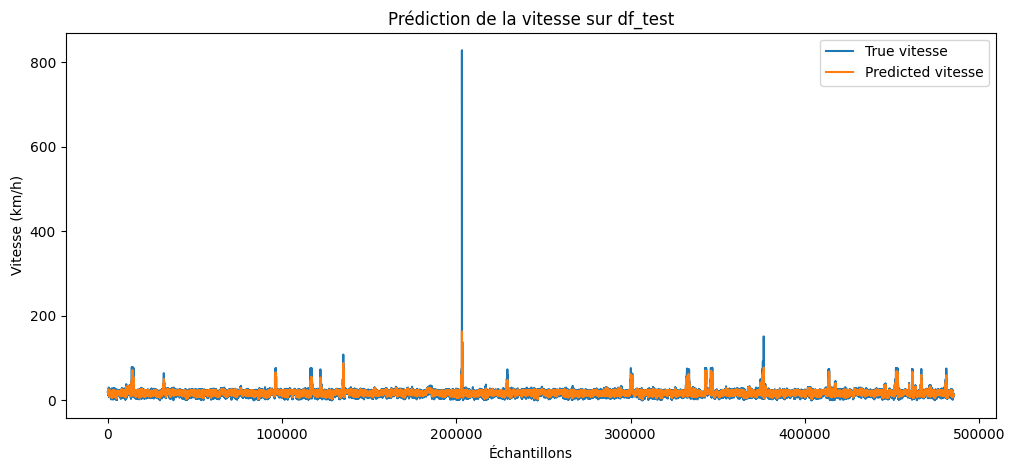

In [ ]:
# Visualisation (optionnelle)
plt.figure(figsize=(12, 5))
plt.plot(y_test_real, label="True vitesse")
plt.plot(y_pred, label="Predicted vitesse")
plt.legend()
plt.title("Prédiction de la vitesse sur df_test")
plt.xlabel("Échantillons")
plt.ylabel("Vitesse (km/h)")
plt.show()



In [ ]:
# Affichage final 
print(df_resultats.head(10))


        heure_arrondie  nom_du_troncon  vitesse_reelle  vitesse_predite
0  2025-03-08 06:00:00  3 Continents I       20.552222        20.016830
1  2025-03-08 06:15:00  3 Continents I       22.000000        20.156460
2  2025-03-08 06:30:00  3 Continents I       20.000000        20.869375
3  2025-03-08 06:45:00  3 Continents I       19.000000        20.133821
4  2025-03-08 07:00:00  3 Continents I       21.936000        19.480972
5  2025-03-08 07:15:00  3 Continents I       22.000000        20.645582
6  2025-03-08 07:30:00  3 Continents I       19.636667        20.986635
7  2025-03-08 07:45:00  3 Continents I       22.000000        20.022287
8  2025-03-08 08:00:00  3 Continents I       19.826667        20.912663
9  2025-03-08 08:15:00  3 Continents I       19.000000        20.092525


c:\projet_mobility_urbaine\AI_model_urban_mobility\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 300s 8ms/step - loss: 3.1774e-05 - val_loss: 8.3639e-06
Epoch 2/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 300s 8ms/step - loss: 8.3699e-06 - val_loss: 7.8843e-06
Epoch 3/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 300s 8ms/step - loss: 8.1471e-06 - val_loss: 8.4012e-06
Epoch 4/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 302s 8ms/step - loss: 8.2175e-06 - val_loss: 7.9020e-06
Epoch 5/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 302s 8ms/step - loss: 8.0666e-06 - val_loss: 8.0083e-06
Epoch 6/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 302s 8ms/step - loss: 8.0249e-06 - val_loss: 7.8996e-06
Epoch 7/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 301s 8ms/step - loss: 7.9815e-06 - val_loss: 7.8849e-06
Epoch 8/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 301s 8ms/step - loss: 7.9734e-06 - val_loss: 7.8315e-06
Epoch 9/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 301s 8ms/step - loss: 7.9820e-06 - val_loss: 7.9294e-06
Epoch 10/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 302s 8ms/step - loss: 7.9481e-06 - val_loss: 8.4733e-06

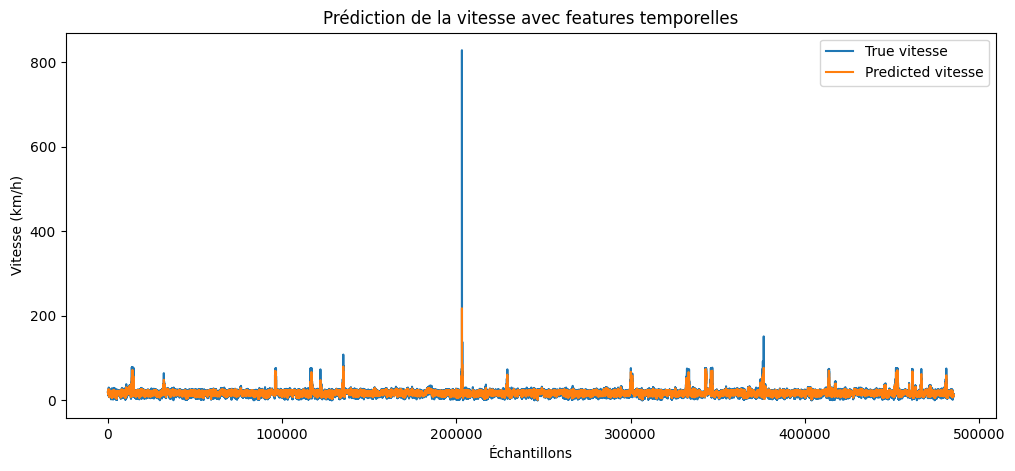

        heure_arrondie  nom_du_troncon  vitesse_reelle  vitesse_predite
0  2025-03-08 06:00:00  3 Continents I       20.552222        19.063654
1  2025-03-08 06:15:00  3 Continents I       22.000000        19.209795
2  2025-03-08 06:30:00  3 Continents I       20.000000        20.023499
3  2025-03-08 06:45:00  3 Continents I       19.000000        19.154438
4  2025-03-08 07:00:00  3 Continents I       21.936000        18.494606
5  2025-03-08 07:15:00  3 Continents I       22.000000        19.804976
6  2025-03-08 07:30:00  3 Continents I       19.636667        20.105778
7  2025-03-08 07:45:00  3 Continents I       22.000000        19.052834
8  2025-03-08 08:00:00  3 Continents I       19.826667        20.085659
9  2025-03-08 08:15:00  3 Continents I       19.000000        19.134113


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Chargement des données 
df = pd.read_parquet("C:/Users/lisas/Downloads/df_final_15min_NoNan_20250505.parquet", engine="fastparquet")
df["heure_arrondie"] = pd.to_datetime(df["heure_arrondie"])
df = df.sort_values("heure_arrondie")

# Ajout de features temporelles
df["hour"] = df["heure_arrondie"].dt.hour
df["weekday"] = df["heure_arrondie"].dt.dayofweek

# Normalisation des features numériques 
scaler_vitesse = MinMaxScaler()
scaler_hour = MinMaxScaler()
scaler_weekday = MinMaxScaler()

df["vitesse_scaled"] = scaler_vitesse.fit_transform(df[["vitesse"]])
df["hour_scaled"] = scaler_hour.fit_transform(df[["hour"]])
df["weekday_scaled"] = scaler_weekday.fit_transform(df[["weekday"]])

# Sélection des colonnes utiles 
features = [
    "vitesse_scaled",
    "hour_scaled",
    "weekday_scaled",
    "is_vacances",
    "is_ferie"
]

# Découpage train / test
df_train = df[df["heure_arrondie"] <= "2025-03-07"].copy()
df_test  = df[df["heure_arrondie"] >= "2025-03-08"].copy()

# Fonction pour créer des séquences multivariées 
def make_sequences_with_features(df, feature_cols, target_col='vitesse_scaled', time_col='heure_arrondie', id_col='nom_du_troncon', window_size=24):
    X, y, times, troncons = [], [], [], []
    for troncon, group in df.groupby(id_col):
        group = group.sort_values(time_col)
        feature_vals = group[feature_cols].values
        target_vals = group[target_col].values
        times_vals = group[time_col].values
        for i in range(len(group) - window_size):
            X.append(feature_vals[i:i+window_size])
            y.append(target_vals[i+window_size])
            times.append(times_vals[i+window_size])
            troncons.append(troncon)
    return np.array(X), np.array(y), times, troncons

# Création des séquences
window_size = 24
X_train, y_train, times_train, troncons_train = make_sequences_with_features(df_train, feature_cols=features, window_size=window_size)
X_test, y_test, times_test, troncons_test = make_sequences_with_features(df_test, feature_cols=features, window_size=window_size)

# Modèle LSTM multivarié
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, len(features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Prédictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_vitesse.inverse_transform(y_pred_scaled)
y_test_real = scaler_vitesse.inverse_transform(y_test.reshape(-1, 1))

# Résultats alignés
df_resultats = pd.DataFrame({
    'heure_arrondie': pd.to_datetime(times_test),
    'nom_du_troncon': troncons_test,
    'vitesse_reelle': y_test_real.flatten(),
    'vitesse_predite': y_pred.flatten()
})
df_resultats['heure_arrondie'] = df_resultats['heure_arrondie'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Visualisation (optionnelle)
plt.figure(figsize=(12, 5))
plt.plot(y_test_real, label="True vitesse")
plt.plot(y_pred, label="Predicted vitesse")
plt.legend()
plt.title("Prédiction de la vitesse avec features temporelles")
plt.xlabel("Échantillons")
plt.ylabel("Vitesse (km/h)")
plt.show()

# Affichage final
print(df_resultats.head(10))



In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_real, y_pred)
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))


print(f"MAE : {mae:.2f} km/h")
print(f"RMSE : {rmse:.2f} km/h")


MAE : 1.54 km/h
RMSE : 2.62 km/h


L’erreur moyenne absolue entre la vitesse réelle et la vitesse prédite. Ici, en moyenne, tes prédictions sont à ±1.54 km/h de la réalité.

c:\projet_mobility_urbaine\AI_model_urban_mobility\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 307s 8ms/step - loss: 4.8573e-04 - val_loss: 3.8422e-04
Epoch 2/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 313s 9ms/step - loss: 3.7915e-04 - val_loss: 3.8013e-04
Epoch 3/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 315s 9ms/step - loss: 3.7663e-04 - val_loss: 3.8887e-04
Epoch 4/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 314s 9ms/step - loss: 3.7097e-04 - val_loss: 3.8321e-04
Epoch 5/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 312s 9ms/step - loss: 3.7003e-04 - val_loss: 3.7707e-04
Epoch 6/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 310s 9ms/step - loss: 3.7416e-04 - val_loss: 3.7806e-04
Epoch 7/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 314s 9ms/step - loss: 3.6646e-04 - val_loss: 3.7785e-04
Epoch 8/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 311s 9ms/step - loss: 3.6874e-04 - val_loss: 3.7894e-04
Epoch 9/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 310s 9ms/step - loss: 3.6338e-04 - val_loss: 3.9016e-04
Epoch 10/10
36233/36233 ━━━━━━━━━━━━━━━━━━━━ 310s 9ms/step - loss: 3.6512e-04 - val_loss: 3.8203e-04

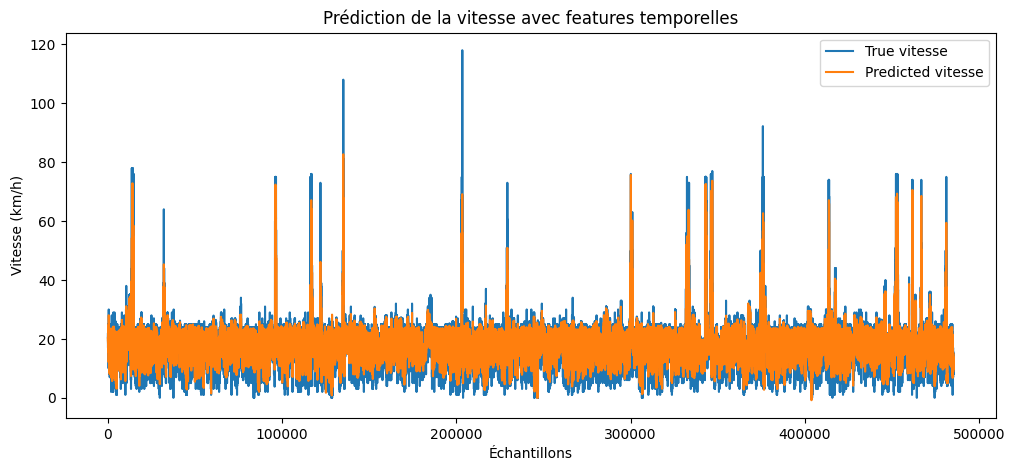

        heure_arrondie  nom_du_troncon  vitesse_reelle  vitesse_predite
0  2025-03-08 06:00:00  3 Continents I       20.552222        19.491320
1  2025-03-08 06:15:00  3 Continents I       22.000000        19.672850
2  2025-03-08 06:30:00  3 Continents I       20.000000        20.482962
3  2025-03-08 06:45:00  3 Continents I       19.000000        19.527000
4  2025-03-08 07:00:00  3 Continents I       21.936000        18.809261
5  2025-03-08 07:15:00  3 Continents I       22.000000        20.158930
6  2025-03-08 07:30:00  3 Continents I       19.636667        20.416166
7  2025-03-08 07:45:00  3 Continents I       22.000000        19.363411
8  2025-03-08 08:00:00  3 Continents I       19.826667        20.332933
9  2025-03-08 08:15:00  3 Continents I       19.000000        19.483139


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Chargement des données & nettoyage 
df = pd.read_parquet("C:/Users/lisas/Downloads/df_final_15min_NoNan_20250505.parquet", engine="fastparquet")
df["heure_arrondie"] = pd.to_datetime(df["heure_arrondie"])
df = df[df["vitesse"] <= 130].copy()  # Supprimer les vitesses aberrantes
df = df.sort_values("heure_arrondie")

# Ajout de features temporelles
df["hour"] = df["heure_arrondie"].dt.hour
df["weekday"] = df["heure_arrondie"].dt.dayofweek

# Normalisation des features numériques
scaler_vitesse = MinMaxScaler()
scaler_hour = MinMaxScaler()
scaler_weekday = MinMaxScaler()

df["vitesse_scaled"] = scaler_vitesse.fit_transform(df[["vitesse"]])
df["hour_scaled"] = scaler_hour.fit_transform(df[["hour"]])
df["weekday_scaled"] = scaler_weekday.fit_transform(df[["weekday"]])

# Sélection des colonnes utiles
features = [
    "vitesse_scaled",
    "hour_scaled",
    "weekday_scaled",
    "is_vacances",
    "is_ferie"
]

# Découpage train / test
df_train = df[df["heure_arrondie"] <= "2025-03-07"].copy()
df_test  = df[df["heure_arrondie"] >= "2025-03-08"].copy()

# Fonction pour créer des séquences multivariées 
def make_sequences_with_features(df, feature_cols, target_col='vitesse_scaled', time_col='heure_arrondie', id_col='nom_du_troncon', window_size=24):
    X, y, times, troncons = [], [], [], []
    for troncon, group in df.groupby(id_col):
        group = group.sort_values(time_col)
        feature_vals = group[feature_cols].values
        target_vals = group[target_col].values
        times_vals = group[time_col].values
        for i in range(len(group) - window_size):
            X.append(feature_vals[i:i+window_size])
            y.append(target_vals[i+window_size])
            times.append(times_vals[i+window_size])
            troncons.append(troncon)
    return np.array(X), np.array(y), times, troncons

# Création des séquences
window_size = 24
X_train, y_train, times_train, troncons_train = make_sequences_with_features(df_train, feature_cols=features, window_size=window_size)
X_test, y_test, times_test, troncons_test = make_sequences_with_features(df_test, feature_cols=features, window_size=window_size)

# Modèle LSTM multivarié
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, len(features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Prédictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_vitesse.inverse_transform(y_pred_scaled)
y_test_real = scaler_vitesse.inverse_transform(y_test.reshape(-1, 1))

# Résultats alignés
df_resultats = pd.DataFrame({
    'heure_arrondie': pd.to_datetime(times_test),
    'nom_du_troncon': troncons_test,
    'vitesse_reelle': y_test_real.flatten(),
    'vitesse_predite': y_pred.flatten()
})
df_resultats['heure_arrondie'] = df_resultats['heure_arrondie'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Visualisation (optionnelle)
plt.figure(figsize=(12, 5))
plt.plot(y_test_real, label="True vitesse")
plt.plot(y_pred, label="Predicted vitesse")
plt.legend()
plt.title("Prédiction de la vitesse avec features temporelles")
plt.xlabel("Échantillons")
plt.ylabel("Vitesse (km/h)")
plt.show()

# Affichage final 
print(df_resultats.head(10))


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Crée une copie de df_resultats pour éviter d'altérer l'original
df_eval = df_resultats.copy()
df_eval["vitesse_reelle"] = df_eval["vitesse_reelle"].astype(float)
df_eval["vitesse_predite"] = df_eval["vitesse_predite"].astype(float)

# Définir les tranches de vitesse
bins = [0, 10, 20, 30, 40, 50, 70, 90, 110, 130]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50","50-70", "70-90", "90-110","110-130"]

df_eval["tranche_vitesse"] = pd.cut(df_eval["vitesse_reelle"], bins=bins, labels=labels, right=False)

# Calculer MAE et RMSE pour chaque tranche
results = []
for label in labels:
    subset = df_eval[df_eval["tranche_vitesse"] == label]
    if len(subset) > 0:
        mae = mean_absolute_error(subset["vitesse_reelle"], subset["vitesse_predite"])
        rmse = np.sqrt(mean_squared_error(subset["vitesse_reelle"], subset["vitesse_predite"]))
        results.append({"Tranche": label, "MAE (km/h)": round(mae, 2), "RMSE (km/h)": round(rmse, 2), "N": len(subset)})

# Créer et afficher le DataFrame des résultats
df_errors_by_range = pd.DataFrame(results)
print(df_errors_by_range)


   Tranche  MAE (km/h)  RMSE (km/h)       N
0     0-10        3.80         5.23   15497
1    10-20        1.15         1.75  304362
2    20-30        1.32         2.03  155565
3    30-40        2.88         4.36    7439
4    40-50        4.99         6.93    1322
5    50-70        8.46        11.40     927
6    70-90       15.60        20.86     233
7   90-110       45.49        45.74       2
8  110-130       76.20        76.23       2


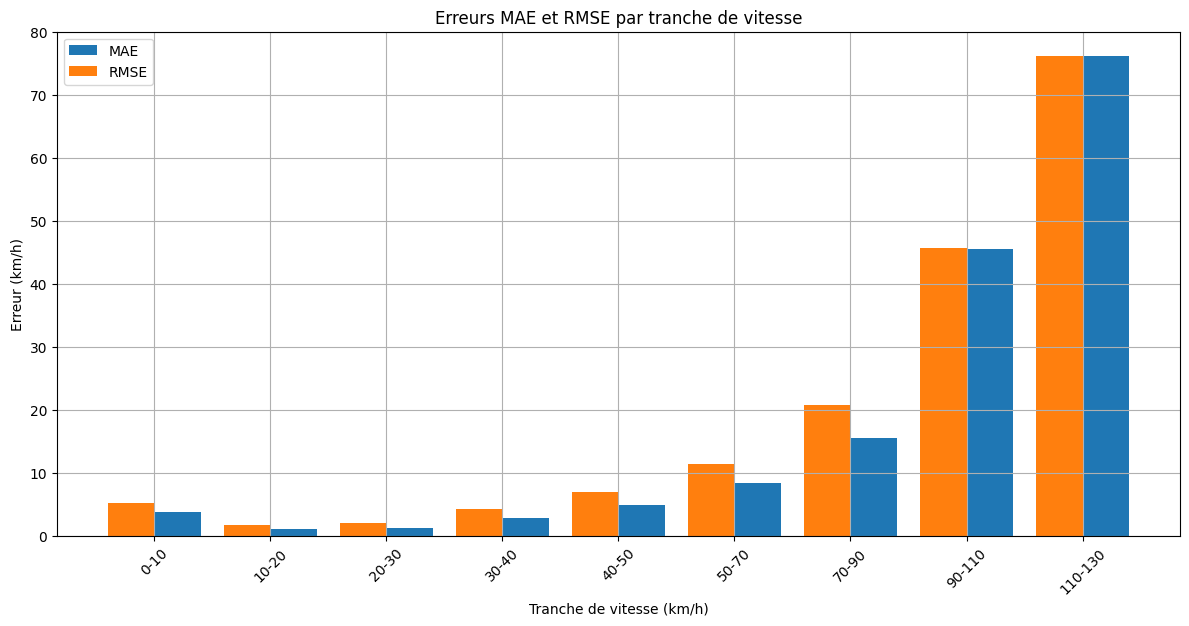

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
x = df_errors_by_range["Tranche"]

plt.bar(x, df_errors_by_range["MAE (km/h)"], width=0.4, label="MAE", align='edge')
plt.bar(x, df_errors_by_range["RMSE (km/h)"], width=-0.4, label="RMSE", align='edge')

plt.title("Erreurs MAE et RMSE par tranche de vitesse")
plt.xlabel("Tranche de vitesse (km/h)")
plt.ylabel("Erreur (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


['3 Continents I' '3 Continents P' '50 Otages I2' '50 Otages I3'
 '50 Otages I4' '50 Otages P1' '50 Otages P2' '50 Otages P3'
 'Aiguillon I1' 'Aiguillon I2']


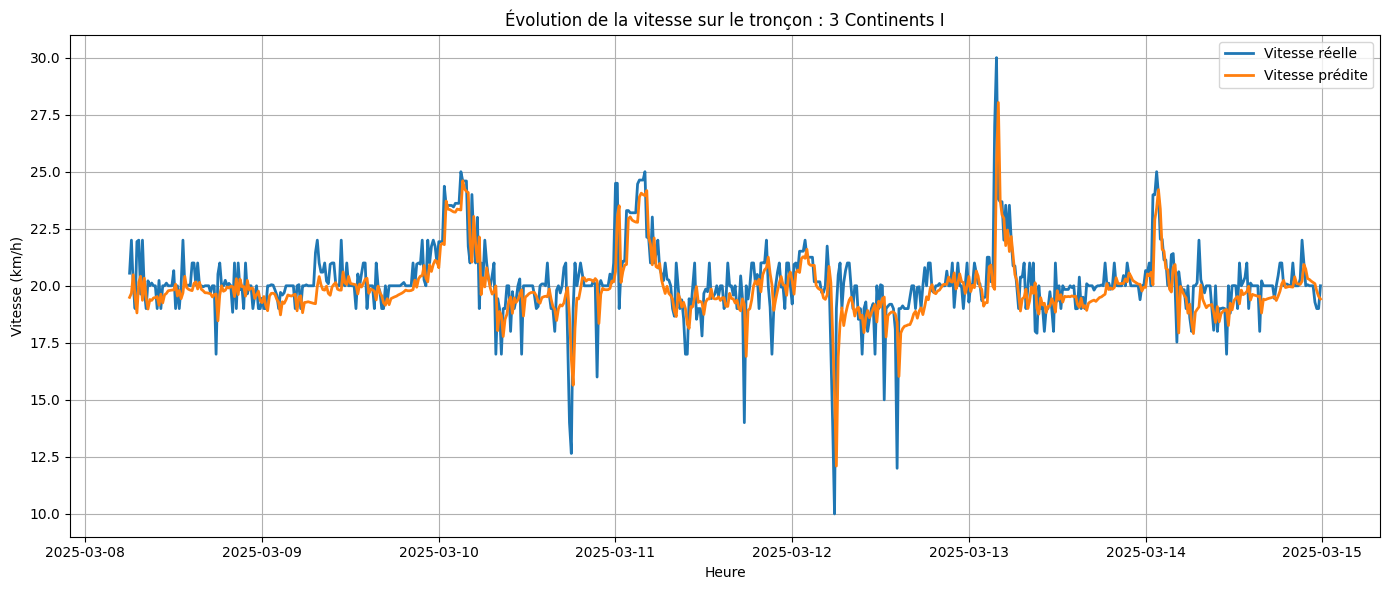

In [ ]:
import matplotlib.pyplot as plt


# Nom du tronçon à visualiser (exemple : à adapter selon ta base)
troncon_cible = "3 Continents I" 

# Filtrer les données pour ce tronçon
df_troncon = df_resultats[df_resultats["nom_du_troncon"] == troncon_cible].copy()
df_troncon["heure_arrondie"] = pd.to_datetime(df_troncon["heure_arrondie"])
df_troncon = df_troncon.sort_values("heure_arrondie")

# Tracer le graphique
plt.figure(figsize=(14, 6))
plt.plot(df_troncon["heure_arrondie"], df_troncon["vitesse_reelle"], label="Vitesse réelle", linewidth=2)
plt.plot(df_troncon["heure_arrondie"], df_troncon["vitesse_predite"], label="Vitesse prédite", linewidth=2)
plt.title(f"Évolution de la vitesse sur le tronçon : {troncon_cible}")
plt.xlabel("Heure")
plt.ylabel("Vitesse (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Meilleure version

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [27]:
# --- 1. Chargement des données & nettoyage ---
df = pd.read_parquet("C:/Users/lisas/Downloads/df_final_15min_NoNan_20250505.parquet", engine="fastparquet")
df["heure_arrondie"] = pd.to_datetime(df["heure_arrondie"])

In [28]:
print("Vitesse min : ", df["vitesse"].min(), "km/h")
print("Vitesse max : ", df["vitesse"].max(), "km/h")
print(df.shape)
df[df["vitesse"] < 50].sort_values("vitesse", ascending=False).shape


Vitesse min :  0.0 km/h
Vitesse max :  828.0 km/h
(1880739, 57)


(1876275, 57)

~99.8% des valeurs de la vitesse < 50 km/h

In [ ]:
# Supprimer les vitesses > 50 km/h
df = df[df["vitesse"] <= 50].copy()

df = df.sort_values("heure_arrondie")

In [ ]:
# Ajout de features temporelles ---
df["hour"] = df["heure_arrondie"].dt.hour
df["weekday"] = df["heure_arrondie"].dt.dayofweek

In [ ]:
# Normalisation des features numériques ---
scaler_vitesse = MinMaxScaler()
scaler_hour = MinMaxScaler()
scaler_weekday = MinMaxScaler()

df["vitesse_scaled"] = scaler_vitesse.fit_transform(df[["vitesse"]])
df["hour_scaled"] = scaler_hour.fit_transform(df[["hour"]])
df["weekday_scaled"] = scaler_weekday.fit_transform(df[["weekday"]])

In [ ]:
# Sélection des colonnes utiles ---
features = [
    "vitesse_scaled",
    "hour_scaled",
    "weekday_scaled",
    "is_vacances",
    "is_ferie"
]

In [ ]:
# Découpage train / test ---
df_train = df[df["heure_arrondie"] <= "2025-03-07"].copy()
df_test  = df[df["heure_arrondie"] >= "2025-03-08"].copy()

In [ ]:
#  Fonction pour créer des séquences multivariées ---
def make_sequences_with_features(df, feature_cols, target_col='vitesse_scaled', time_col='heure_arrondie', id_col='nom_du_troncon', window_size=24):
    X, y, times, troncons = [], [], [], []
    for troncon, group in df.groupby(id_col):
        group = group.sort_values(time_col)
        feature_vals = group[feature_cols].values
        target_vals = group[target_col].values
        times_vals = group[time_col].values
        for i in range(len(group) - window_size):
            X.append(feature_vals[i:i+window_size])
            y.append(target_vals[i+window_size])
            times.append(times_vals[i+window_size])
            troncons.append(troncon)
    return np.array(X), np.array(y), times, troncons

In [ ]:
# Création des séquences
window_size = 24
X_train, y_train, times_train, troncons_train = make_sequences_with_features(df_train, feature_cols=features, window_size=window_size)
X_test, y_test, times_test, troncons_test = make_sequences_with_features(df_test, feature_cols=features, window_size=window_size)

In [ ]:

# Modèle LSTM multivarié 
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, len(features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 334s 9ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 2/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 309s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 306s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 311s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 306s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 310s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 309s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 309s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 314s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/10
36153/36153 ━━━━━━━━━━━━━━━━━━━━ 316s 9ms/step - loss: 0.0017 - val_loss: 0.0018


In [ ]:


# Prédictions 
y_pred_scaled = model.predict(X_test)
y_pred = scaler_vitesse.inverse_transform(y_pred_scaled)
y_test_real = scaler_vitesse.inverse_transform(y_test.reshape(-1, 1))


15132/15132 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step


In [ ]:

# Résultats alignés 
df_resultats = pd.DataFrame({
    'heure_arrondie': pd.to_datetime(times_test),
    'nom_du_troncon': troncons_test,
    'vitesse_reelle': y_test_real.flatten(),
    'vitesse_predite': y_pred.flatten()
})
df_resultats['heure_arrondie'] = df_resultats['heure_arrondie'].dt.strftime('%Y-%m-%d %H:%M:%S')

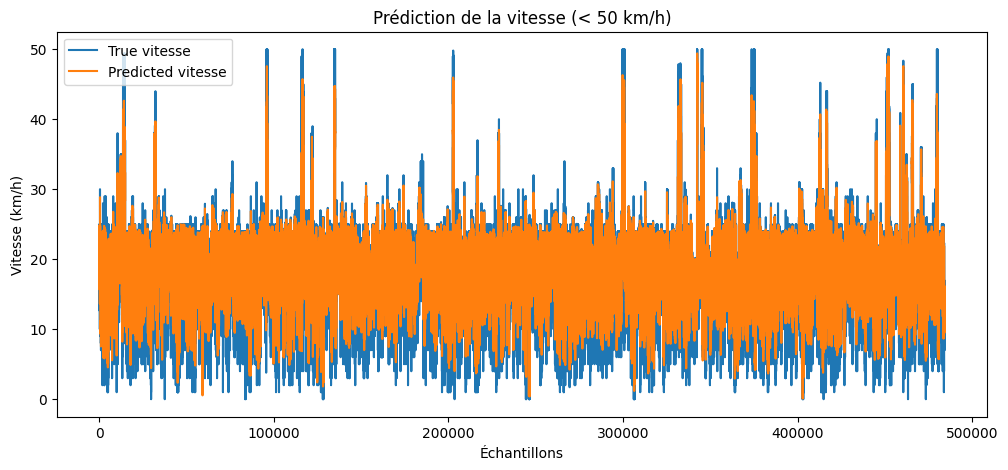

        heure_arrondie  nom_du_troncon  vitesse_reelle  vitesse_predite
0  2025-03-08 06:00:00  3 Continents I       20.552222        20.149572
1  2025-03-08 06:15:00  3 Continents I       22.000000        20.256884
2  2025-03-08 06:30:00  3 Continents I       20.000000        21.154140
3  2025-03-08 06:45:00  3 Continents I       19.000000        20.260792
4  2025-03-08 07:00:00  3 Continents I       21.936000        19.494596
5  2025-03-08 07:15:00  3 Continents I       22.000000        20.835747
6  2025-03-08 07:30:00  3 Continents I       19.636667        21.260601
7  2025-03-08 07:45:00  3 Continents I       22.000000        20.096022
8  2025-03-08 08:00:00  3 Continents I       19.826667        21.111103
9  2025-03-08 08:15:00  3 Continents I       19.000000        20.170547


In [ ]:
# Visualisation
plt.figure(figsize=(12, 5))
plt.plot(y_test_real, label="True vitesse")
plt.plot(y_pred, label="Predicted vitesse")
plt.legend()
plt.title("Prédiction de la vitesse (< 50 km/h)")
plt.xlabel("Échantillons")
plt.ylabel("Vitesse (km/h)")
plt.show()

# Affichage final
print(df_resultats.head(10))



In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_real, y_pred)
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))


print(f"MAE : {mae:.2f} km/h")
print(f"RMSE : {rmse:.2f} km/h")


MAE : 1.27 km/h
RMSE : 2.09 km/h


['3 Continents I' '3 Continents P' '50 Otages I2' '50 Otages I3'
 '50 Otages I4' '50 Otages P1' '50 Otages P2' '50 Otages P3'
 'Aiguillon I1' 'Aiguillon I2']


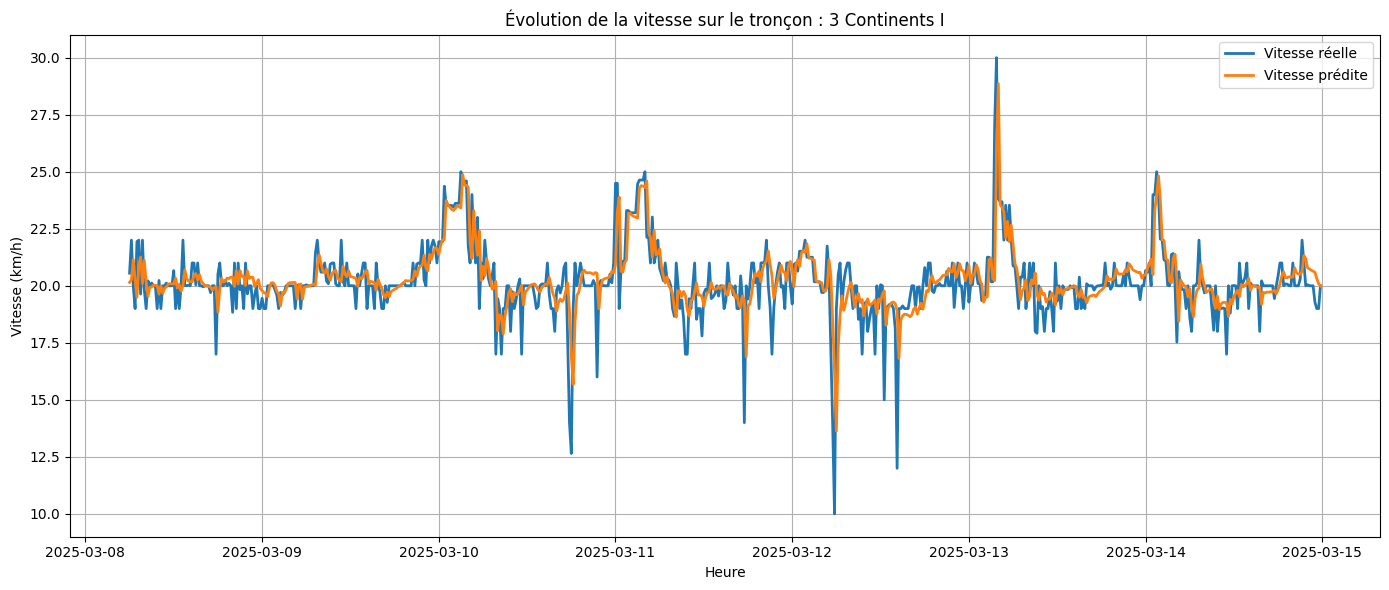

In [ ]:
import matplotlib.pyplot as plt


# Nom du tronçon à visualiser (exemple : à adapter selon ta base)
troncon_cible = "3 Continents I"  

# Filtrer les données pour ce tronçon
df_troncon = df_resultats[df_resultats["nom_du_troncon"] == troncon_cible].copy()
df_troncon["heure_arrondie"] = pd.to_datetime(df_troncon["heure_arrondie"])
df_troncon = df_troncon.sort_values("heure_arrondie")

# Tracer le graphique
plt.figure(figsize=(14, 6))
plt.plot(df_troncon["heure_arrondie"], df_troncon["vitesse_reelle"], label="Vitesse réelle", linewidth=2)
plt.plot(df_troncon["heure_arrondie"], df_troncon["vitesse_predite"], label="Vitesse prédite", linewidth=2)
plt.title(f"Évolution de la vitesse sur le tronçon : {troncon_cible}")
plt.xlabel("Heure")
plt.ylabel("Vitesse (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_resultats.to_csv("resultats_multivariates_sans_sup_50.csv", index=False)